### Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Initial load, clean, and merge

In [15]:
df_rechnung_total = pd.read_parquet('Rechnungen.parquet')
rechnung_columns = ["Unternehmen", "Artikel_SK", "Auftragsdatum_SK", "Kunde_Verkauf_SK", "Umsatztyp", "Preis Verpackungseinheit", "Menge", "Nettoumsatz", "Productgroup", "Productsubgroup", "Business Area", "Type"]
df_rechnung = df_rechnung_total[rechnung_columns]

df_kunden_total = pd.read_csv('Kunden.csv', sep=';', low_memory=False)
kunden_columns = ["Kunde_SK", "Ort", "PLZ-Code", "Branchengruppe", "Vertriebskanalkategorie", "Vertriebskanal"]
df_kunden = df_kunden_total[kunden_columns]
df_kunden = df_kunden.rename(columns={"Kunde_SK": "Kunde_Verkauf_SK"})

df = pd.merge(df_rechnung, df_kunden, on="Kunde_Verkauf_SK")

# Translate to English
df = df.rename(columns={
    "Artikel_SK": "ArticleID",
    "Unternehmen": "Company",
    "Auftragsdatum_SK": "OrderDate",
    "Kunde_Verkauf_SK": "CustomerID",
    "Umsatztyp": "RevenueType",
    "Preis Verpackungseinheit": "PricePackagingUnit",
    "Menge": "Quantity",
    "Nettoumsatz": "NetRevenue",
    "Productgroup": "ProductGroup",
    "Productsubgroup": "ProductSubgroup",
    "Business Area": "BusinessArea",
    "Type": "Type",
    "Ort": "City",
    "Vertriebskanalkategorie": "SalesChannelCategory",
    "Vertriebskanal": "SalesChannel",
    "PLZ-Code": "PostalCode",
    "Branchengruppe": "IndustryGroup"
    }
)

df['CustomerID'] = df['CustomerID'].astype(str)
df['SalesChannel'] = df['SalesChannelCategory'].str.split('_').str[0]
df = df[df['SalesChannel'].isin(['B2B', 'B2C', 'B2B2C'])]

df.to_parquet('Transformed.parquet')

### Cleaning columns

In [19]:
df = pd.read_parquet('Final.parquet')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 20105168 entries, 0 to 20110509
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Company             object 
 1   ArticleID           int64  
 2   OrderDate           int64  
 3   CustomerID          object 
 4   RevenueType         object 
 5   PricePackagingUnit  float64
 6   Quantity            float64
 7   NetRevenue          float64
 8   ProductGroup        object 
 9   ProductSubgroup     object 
 10  BusinessArea        object 
 11  Type                object 
 12  City                object 
 13  PostalCode          object 
 14  IndustryGroup       object 
 15  SalesChannel        object 
dtypes: float64(3), int64(2), object(11)
memory usage: 2.5+ GB
None


### Initial analysis

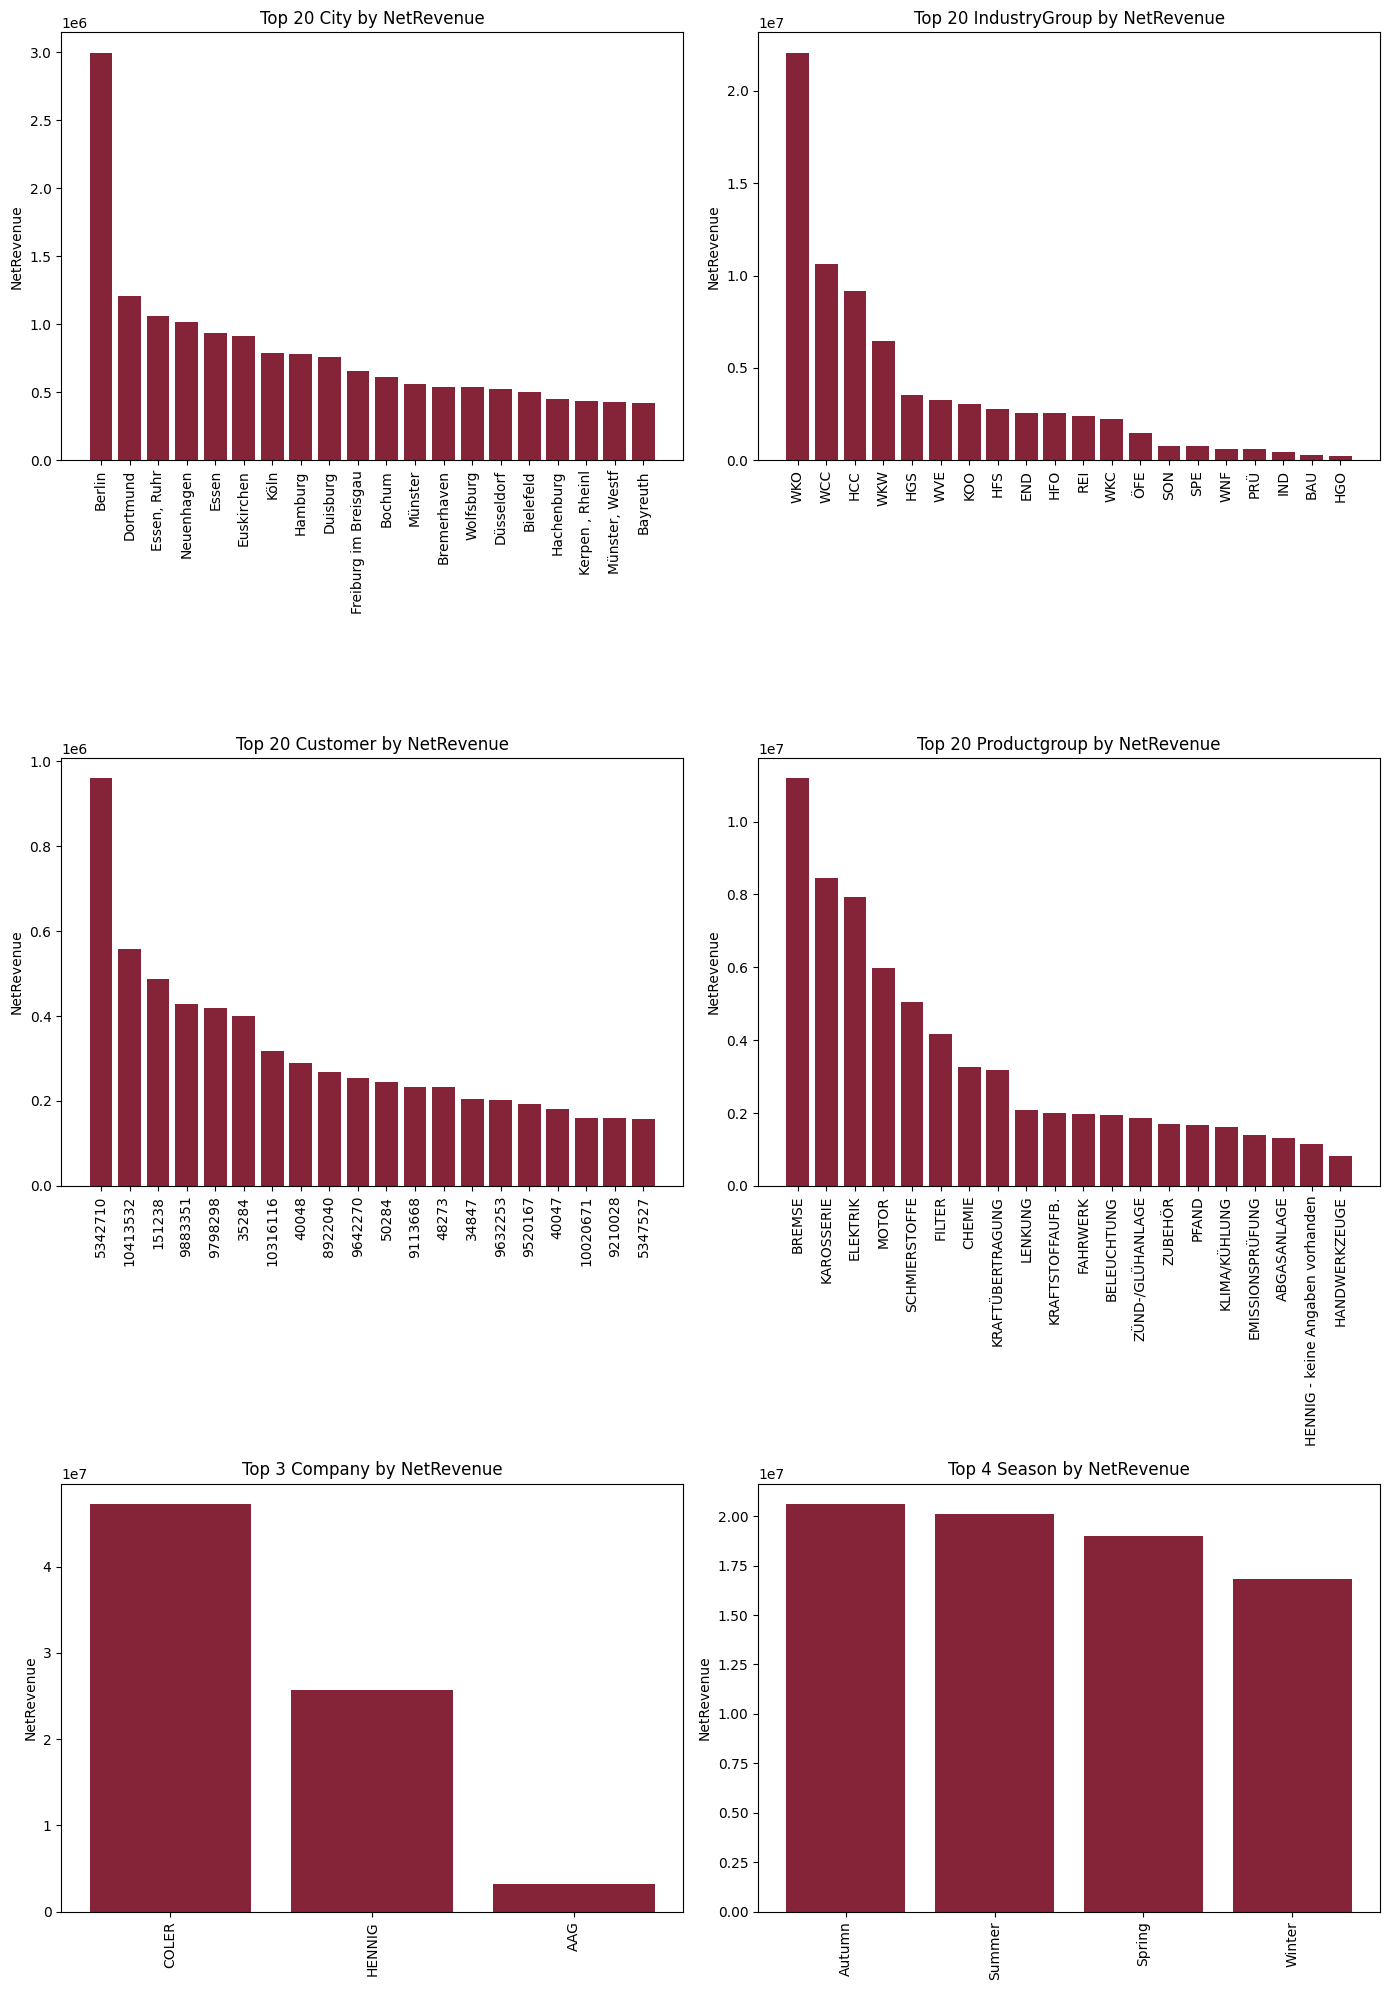

In [3]:
df = pd.read_parquet('Final.parquet')

# Convert SalesDate_SK to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'], format='%Y%m%d')

# Add column for season
def season_from_month(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Unknown'
    
df['Season'] = df['OrderDate'].dt.month.apply(season_from_month)

# Only keep rows in 2023
df = df[df['OrderDate'].dt.year == 2023]

def plot_top_n_by_column(data, group_column, value_column, n, title_suffix='', ax=None):
    if ax is None:
        ax = plt.gca()  # Gets the current axis if none is provided
    result = data.groupby(group_column)[value_column].sum().reset_index()
    result = result.sort_values(value_column, ascending=False).head(n)
    ax.bar(result[group_column], result[value_column], color='#852339')
    ax.set_xticks(range(len(result))) # Prevents overlapping labels
    ax.set_xticklabels(result[group_column], rotation=90)
    ax.set_ylabel(value_column)
    ax.set_title(f'Top {n} {title_suffix} by {value_column}')

fig, axs = plt.subplots(3, 2, figsize=(14, 20))

plot_top_n_by_column(df, 'City', 'NetRevenue', 20, title_suffix='City', ax=axs[0, 0])
plot_top_n_by_column(df, 'IndustryGroup', 'NetRevenue', 20, title_suffix='IndustryGroup', ax=axs[0, 1])
plot_top_n_by_column(df, 'CustomerID', 'NetRevenue', 20, title_suffix='Customer', ax=axs[1, 0])
plot_top_n_by_column(df, 'ProductGroup', 'NetRevenue', 20, title_suffix='Productgroup', ax=axs[1, 1])
plot_top_n_by_column(df, 'Company', 'NetRevenue', 3, title_suffix='Company', ax=axs[2, 0])
plot_top_n_by_column(df, 'Season', 'NetRevenue', 4, title_suffix='Season', ax=axs[2, 1])

plt.tight_layout()
plt.show()

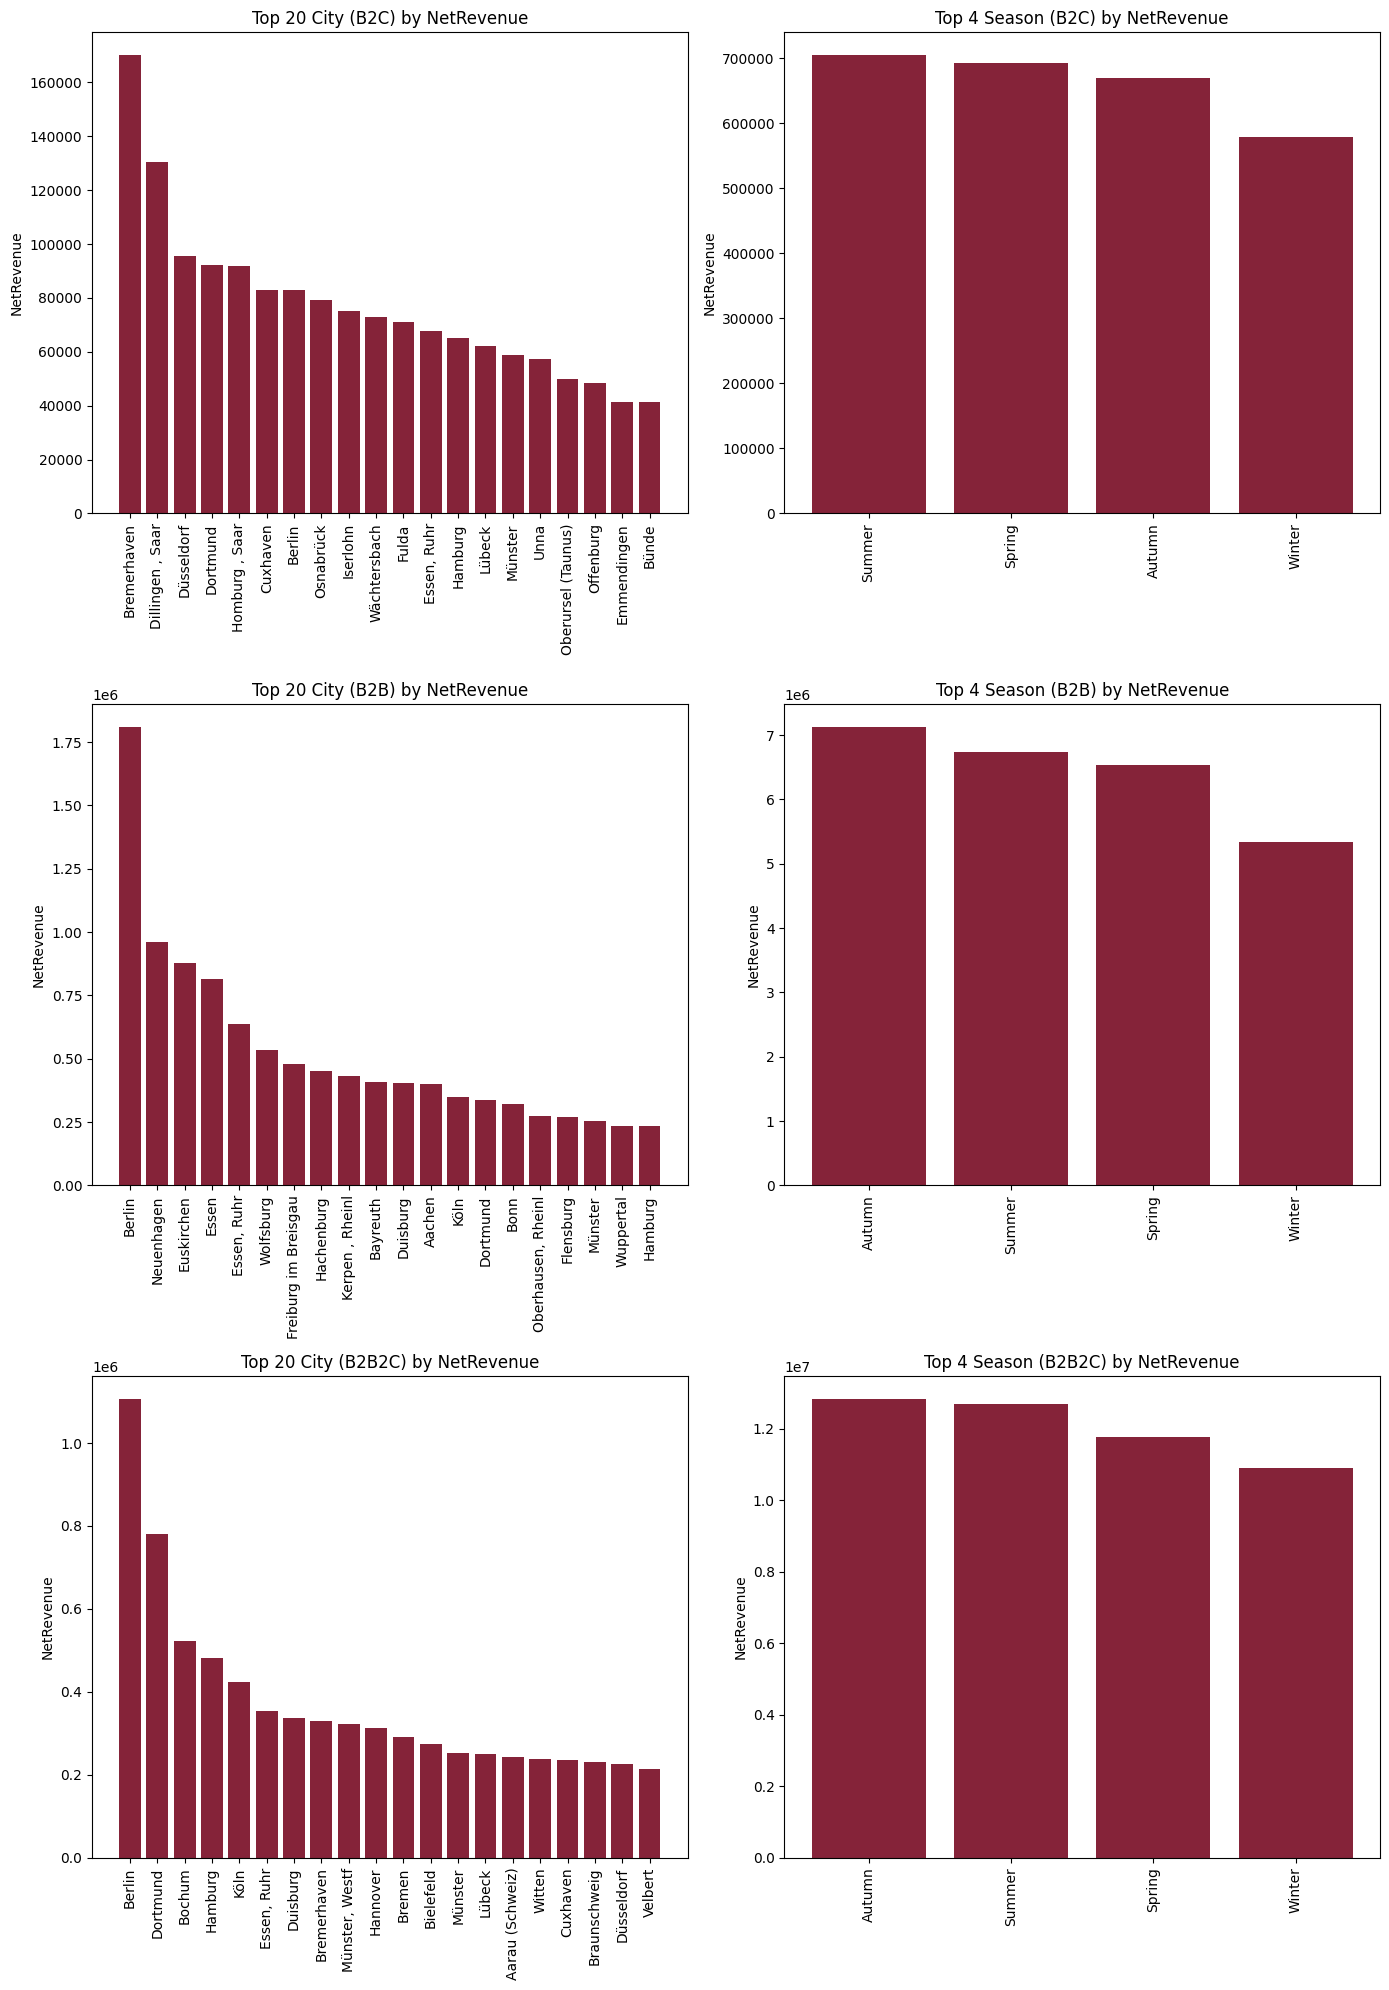

In [4]:
df_b2b = df[df['SalesChannel'] == 'B2B']
df_b2c = df[df['SalesChannel'] == 'B2C']
df_b2b2c = df[df['SalesChannel'] == 'B2B2C']

fig, axs = plt.subplots(3, 2, figsize=(14, 20))

plot_top_n_by_column(df_b2c, 'City', 'NetRevenue', 20, title_suffix='City (B2C)', ax=axs[0, 0])
plot_top_n_by_column(df_b2c, 'Season', 'NetRevenue', 4, title_suffix='Season (B2C)', ax=axs[0, 1])
plot_top_n_by_column(df_b2b, 'City', 'NetRevenue', 20, title_suffix='City (B2B)', ax=axs[1, 0])
plot_top_n_by_column(df_b2b, 'Season', 'NetRevenue', 4, title_suffix='Season (B2B)', ax=axs[1, 1])
plot_top_n_by_column(df_b2b2c, 'City', 'NetRevenue', 20, title_suffix='City (B2B2C)', ax=axs[2, 0])
plot_top_n_by_column(df_b2b2c, 'Season', 'NetRevenue', 4, title_suffix='Season (B2B2C)', ax=axs[2, 1])
plt.tight_layout()
plt.show()

In [3]:
print(df)

          InvoiceNumber  Article_SK  SalesDate_SK Customer_SK  Location_SK  \
0            SGR1300011   106155952      20240501      147456           83   
1            SGR1300011   108629180      20240501      147456           31   
2            SGR1300063   108629180      20240501      147828           31   
3            SGR1300011   104537470      20240501      147456           83   
4         RG13000000213   105814252      20230102      150085           27   
...                 ...         ...           ...         ...          ...   
20110505       93494967   102789878      20240414    10507194          125   
20110506       93494976   103202551      20240414     9353824          114   
20110507       93493719   104231157      20240414    10435133            7   
20110508       93494292   106136151      20240414    10542464            7   
20110509       93493899   104864418      20240414    10316116          111   

             RevenueType  PricePackagingUnit  Quantity  NetReve